In [1]:
import pandas as pd


In [2]:
path = "data/raw/WDICSV.csv"
raw_data= pd.read_csv(path)
print("Success in loading in the data")

Success in loading in the data


In [3]:
print({raw_data.shape})

{(403256, 69)}


In [4]:
#melting the data
years = [col for col in raw_data.columns if col.isdigit()]
id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
melted_data = raw_data.melt(id_vars = id_vars,value_vars = years,var_name="Year",value_name="Value")
#here i change the years to be numeric for easier filter processig
melted_data["Year"] = pd.to_numeric(melted_data["Year"],errors="coerce")

In [5]:
#checking if melted
print({melted_data.shape})

{(26211640, 6)}


In [6]:
#pivoting to make it presented as an N by D matrix(where N is number of datapoints and D is the number of indicators)
pivoted = melted_data.pivot_table(index = ['Country Name', 'Country Code', 'Year'],columns= 'Indicator Name',values='Value').reset_index()
print(pivoted)


Indicator Name Country Name Country Code  Year  \
0               Afghanistan          AFG  1960   
1               Afghanistan          AFG  1961   
2               Afghanistan          AFG  1962   
3               Afghanistan          AFG  1963   
4               Afghanistan          AFG  1964   
...                     ...          ...   ...   
17220              Zimbabwe          ZWE  2020   
17221              Zimbabwe          ZWE  2021   
17222              Zimbabwe          ZWE  2022   
17223              Zimbabwe          ZWE  2023   
17224              Zimbabwe          ZWE  2024   

Indicator Name  ARI treatment (% of children under 5 taken to a health provider)  \
0                                                             NaN                  
1                                                             NaN                  
2                                                             NaN                  
3                                                             N

In [7]:
#saving the processed data
output_path = "data/processed/WDI_pivoted.csv"
pivoted.to_csv(output_path, index=False)


In [8]:
#We now start testing different thresholds using a for loop
thresholds= [(0.3, 0.4), (0.5, 0.6),(0.4, 0.6),(0.6, 0.4),(0.6, 0.6),(0.7, 0.7), (0.5, 0.7), (0.7, 0.8)]#our thresholds
pivoted_copy = pivoted.copy()
features = pivoted_copy.drop(columns=['Country Name', 'Country Code', 'Year'])#keeping only the indicators
meta_data = pivoted[['Country Name', 'Country Code', 'Year']]
results = []# to be used later with t-SNE

for row_thresh ,col_thresh in thresholds:
    #for iterartion we wil create a new copy
    features_copy = features.copy()
    

    #from here we will first filter the rows(Years) and the the columns(Indicators)
    row_completeness = features_copy.notna().mean(axis=1)
    filtered_by_rows = features_copy[row_completeness >=row_thresh]
    #by columns(Indicators)
    column_completeness = filtered_by_rows.notna().mean(axis=0)
    filtered_data = filtered_by_rows.loc[:, column_completeness >= col_thresh]
    filtered_shape = filtered_data.shape

    results.append({'row_threshold': row_thresh,'col_threshold': col_thresh,'data': filtered_data,'row_mask': row_completeness >= row_thresh,'n_rows': filtered_shape[0],'n_cols': filtered_shape[1]})

    print(f"The thresholds for this iteration are ({row_thresh}, {col_thresh}) >>> Final Shape: {filtered_shape}")

chosen = None
for result in results:
    if result['row_threshold'] == 0.4 and result['col_threshold'] == 0.6:
        chosen = result
        break

filtered_data = chosen['data']
rows_kept_mask = chosen['row_mask']

filtered_metadata = meta_data[rows_kept_mask].reset_index(drop=True)

#to check if the number of rows are equal
print(filtered_data.shape[0] == filtered_metadata.shape[0])


The thresholds for this iteration are (0.3, 0.4) >>> Final Shape: (9280, 914)
The thresholds for this iteration are (0.5, 0.6) >>> Final Shape: (4338, 882)
The thresholds for this iteration are (0.4, 0.6) >>> Final Shape: (6665, 785)
The thresholds for this iteration are (0.6, 0.4) >>> Final Shape: (2427, 1106)
The thresholds for this iteration are (0.6, 0.6) >>> Final Shape: (2427, 973)
The thresholds for this iteration are (0.7, 0.7) >>> Final Shape: (469, 1005)
The thresholds for this iteration are (0.5, 0.7) >>> Final Shape: (4338, 768)
The thresholds for this iteration are (0.7, 0.8) >>> Final Shape: (469, 930)
True


In [9]:
def strategy(strategy, data, metadata):
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.manifold import TSNE

    imputer = SimpleImputer(strategy=strategy)
    imputed = imputer.fit_transform(data)

    #normalizing the data
    scaler = StandardScaler()
    scaled = scaler.fit_transform(imputed)

    tsne = TSNE(n_components=2, random_state=42)
    data_tsne = tsne.fit_transform(scaled)

    return data_tsne

In [10]:
tmean = strategy('mean', filtered_data, filtered_metadata)
tmedian = strategy('median', filtered_data, filtered_metadata)

C:\Users\DLDTHA021\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\DLDTHA021\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\DLDTHA021\AppData\Local\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\DLDTHA021\AppData\Local\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, exec

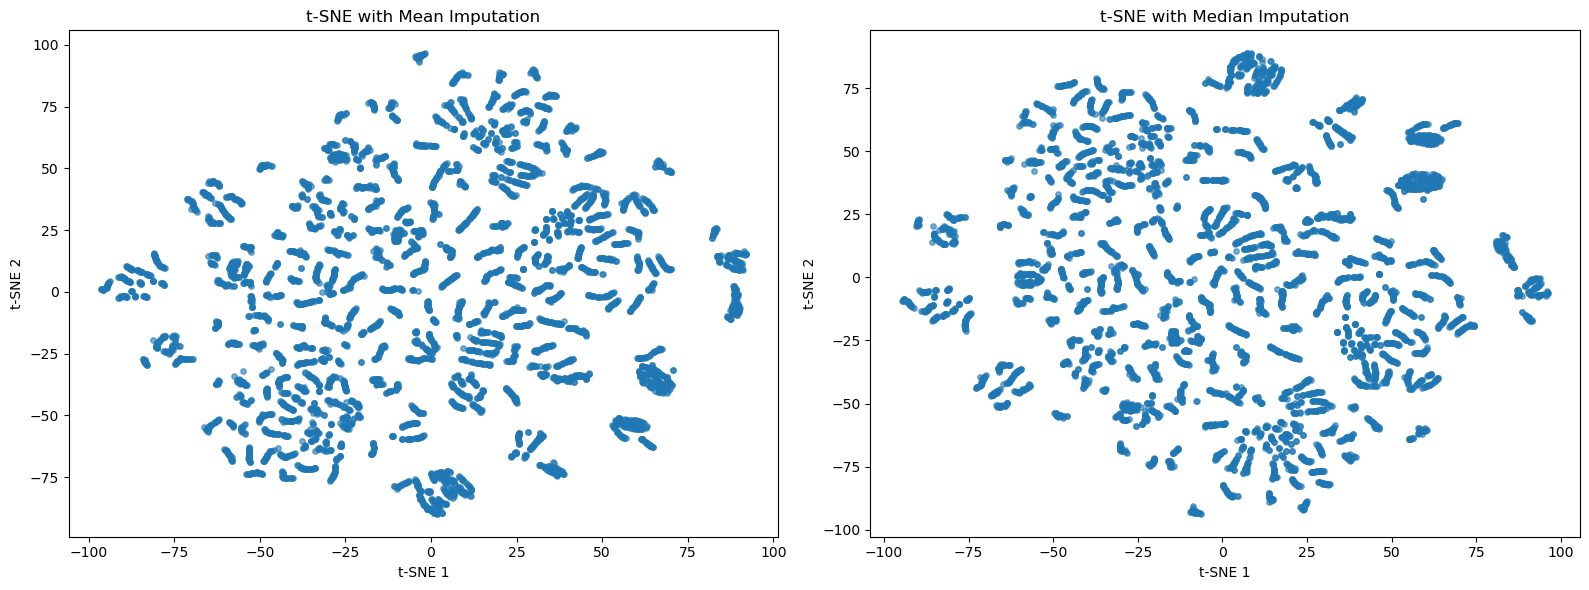

In [11]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(tmean[:, 0], tmean[:, 1], alpha=0.6, s=15)
ax1.set_title('t-SNE with Mean Imputation')
ax1.set_xlabel('t-SNE 1')
ax1.set_ylabel('t-SNE 2')

ax2.scatter(tmedian[:, 0], tmedian[:, 1], alpha=0.6, s=15)
ax2.set_title('t-SNE with Median Imputation')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

C:\Users\DLDTHA021\AppData\Local\Temp\ipykernel_14256\166380006.py:19: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 238
  plt.legend(handles=scatter.legend_elements()[0], labels=list(pd.factorize(categories)[1]), bbox_to_anchor=(1.05, 1), loc='upper left')


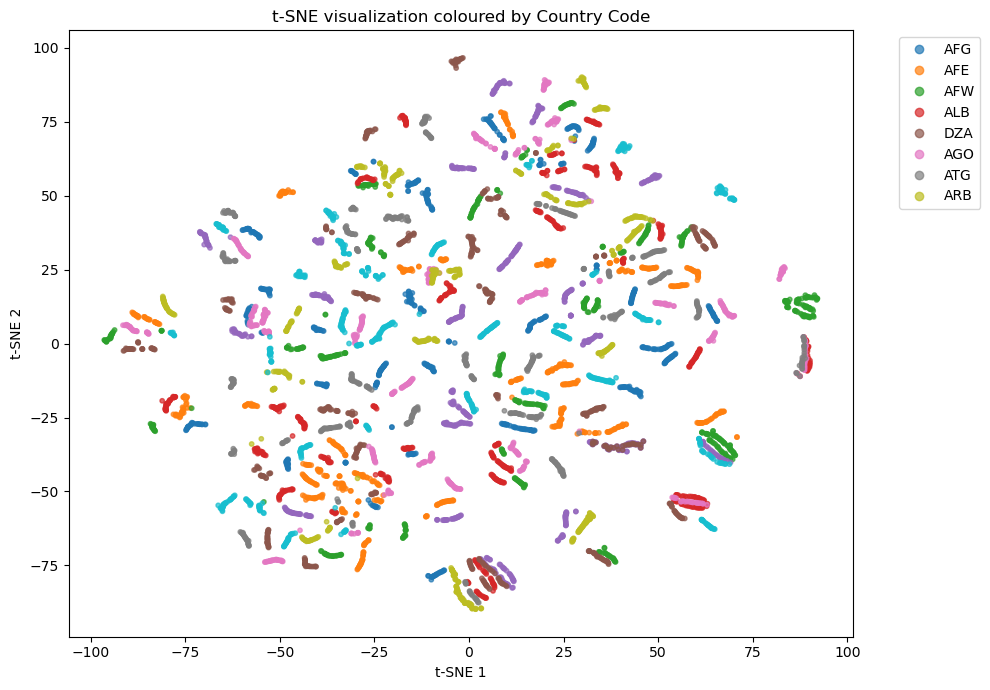

In [12]:

import matplotlib.pyplot as plt

# Example: if 'HDI Category' exists in metadata, otherwise use 'Country Code' or another categorical field like 'Region'
if 'HDI Category' in filtered_metadata.columns:
    categories = filtered_metadata['HDI Category']
    title_label = 'HDI Category'
elif 'Region' in filtered_metadata.columns:
    categories = filtered_metadata['Region']
    title_label = 'Region'
else:
    categories = filtered_metadata['Country Code']
    title_label = 'Country Code'

# Apply t-SNE again (using mean imputation here as example)
tmean = strategy('mean', filtered_data, filtered_metadata)

plt.figure(figsize=(10,7))
scatter = plt.scatter(tmean[:,0], tmean[:,1], c=pd.factorize(categories)[0], cmap='tab10', s=10, alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=list(pd.factorize(categories)[1]), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"t-SNE visualization coloured by {title_label}")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()
